In [1]:
import numpy as np

print(np.__version__)

1.20.1


In [2]:
# prediction
def obs(user_df, item_df):
    Rui_hat = np.matmul(user_df, item_df.T)
    return Rui_hat

# preference score
def pui(Rui):
    Pui = Rui.copy()
    Pui[Pui <= 0] = 0
    Pui[Pui > 1] = 1
    return Pui

# confidence score
def cui(alpha, Rui):
    Cui = 1+alpha*Rui
    return Cui

# loss funcion
def cost_function(Cui, Pui, Rui_hat, X, Y, lmda):
    prediction_error = np.square(Pui - Rui_hat)
    confidence_error = np.sum(Cui * prediction_error)
    regulation_error = lmda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regulation_error
    return np.sum(prediction_error), confidence_error, regulation_error, total_loss

def user_optimizer(X, Y, Cui, Pui, nu, nf, lmda):
    YT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(Cui[u])
        YT_Cu_Y = np.matmul(np.matmul(YT, Cu), Y)
        lmI = np.dot(lmda, np.identity(nf))
        YT_Cu_pu = np.matmul(np.matmul(YT, Cu), Pui[u])
        X[u] = np.linalg.solve(YT_Cu_Y+lmI, YT_Cu_pu)

def item_optimizer(X, Y, Cui, Pui, ni, nf, lmda):
    XT = np.transpose(X)
    for i in range(ni):
        Cu = np.diag(Cui[:, i])
        XT_Cu_Y = np.matmul(np.matmul(XT, Cu), X)
        lmI = np.dot(lmda, np.identity(nf))
        XT_Cu_pu = np.matmul(np.matmul(XT, Cu), Pui[:, i])
        Y[i] = np.linalg.solve(XT_Cu_Y+lmI, XT_Cu_pu)


In [3]:
# interaction matrix
interaction = np.array([[0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
                        [0, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
                        [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
                        [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
                        [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
                        [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
                        [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0]])
# num of users
nu = interaction.shape[0]

# num of items
ni = interaction.shape[1]

# dim of latent vectors
nf = 200

# df_generate
user_df = np.random.rand(nu, nf) * 0.01
item_df = np.random.rand(ni, nf) * 0.01

X = user_df
Y = item_df

print(interaction.shape)

(10, 11)


In [4]:
"""
train step
"""

lmda = 40
alpha = 40

prediction_list = []
confidence_list = []
regulation_list = []
total_losses = []

Rui = interaction
Cui = cui(alpha, Rui)
Pui = pui(Rui)

for i in range(15):
    if i != 0:
        user_optimizer(X, Y, Cui, Pui, nu, nf, lmda)
        item_optimizer(X, Y, Cui, Pui, ni, nf, lmda)
    
    predict = obs(X, Y)
    predict_error, confident_error, regulation_error, total_loss = \
        cost_function(Cui, Pui, predict, X, Y, lmda)

    prediction_list.append(predict_error)
    confidence_list.append(confident_error)
    regulation_list.append(regulation_error)
    total_losses.append(total_loss)
    
    # visualization
    print("-------%d step-------" % i)
    print("predict_error: %f" % predict_error)
    print("confident_error: %f" % confident_error)
    print("regulation_error: %f" % regulation_error)
    print("total_loss: %f" % total_loss)

predict = obs(X, Y)
print("final predict")
print([predict])

-------0 step-------
predict_error: 22.770591
confident_error: 3467.723751
regulation_error: 5.613717
total_loss: 3473.337469
-------1 step-------
predict_error: 31.894195
confident_error: 287.848819
regulation_error: 636.334555
total_loss: 924.183374
-------2 step-------
predict_error: 34.801149
confident_error: 137.582940
regulation_error: 649.816816
total_loss: 787.399756
-------3 step-------
predict_error: 32.831192
confident_error: 119.969652
regulation_error: 650.389782
total_loss: 770.359435
-------4 step-------
predict_error: 30.187868
confident_error: 109.680305
regulation_error: 653.274721
total_loss: 762.955026
-------5 step-------
predict_error: 27.601667
confident_error: 102.696943
regulation_error: 656.284924
total_loss: 758.981867
-------6 step-------
predict_error: 25.413866
confident_error: 97.834529
regulation_error: 658.770331
total_loss: 756.604860
-------7 step-------
predict_error: 23.717930
confident_error: 94.484750
regulation_error: 660.643645
total_loss: 755.1

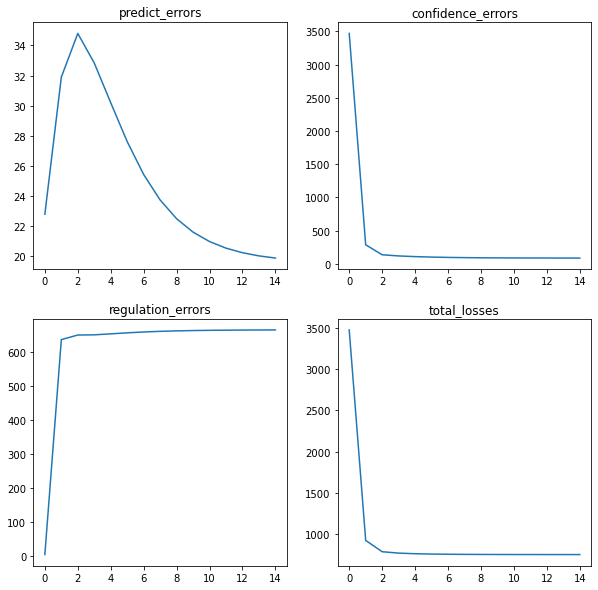

In [5]:
"""
Visualization step
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(prediction_list)
plt.title("predict_errors")

plt.subplot(2, 2, 2)
plt.plot(confidence_list)
plt.title("confidence_errors")

plt.subplot(2, 2, 3)
plt.plot(regulation_list)
plt.title("regulation_errors")

plt.subplot(2, 2, 4)
plt.plot(total_losses)
plt.title("total_losses")

plt.show()